In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
import numpy as np 
import tensorflow as tf 
import keras
from keras import layers , activations , models , preprocessing , utils
import pandas as pd 

Kullanacağımız veriyi http://www.manythings.org/ adresinden indiriyoruz. 

In [4]:
!wget http://www.manythings.org/anki/tur-eng.zip -O tur-eng.zip
!unzip tur-eng.zip

--2020-12-16 06:52:50--  http://www.manythings.org/anki/tur-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 172.67.173.198, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18430277 (18M) [application/zip]
Saving to: ‘tur-eng.zip’

tur-eng.zip         100%[===================>]  17.58M  7.21MB/s    in 2.4s    

2020-12-16 06:52:53 (7.21 MB/s) - ‘tur-eng.zip’ saved [18430277/18430277]

Archive:  tur-eng.zip
  inflating: tur.txt                 
  inflating: _about.txt              


## Verilerin Okunması 
Veriileri okuyabilmek için **read_table** kullanıyoruz, names ile sutun isimlerini veriyoruz. index_col=False ile de ilk sutunun index sutunu olarak geçmesini istemediğimizi belirtiyoruz. <br>
Datanın hepsini kullanmak istesekde colabda **ram** yetmiyor. Bu sebepler verinin içerisinden ufak bir sample alıyoruz

In [5]:
data = pd.read_table("tur.txt",names=["english","turkish"],index_col=False)
data = data.iloc[:20000]
data.head()

,english,turkish
0,Hi.,Selam.
1,Hi.,Merhaba.
2,Run!,Kaç!
3,Run!,Koş!
4,Run.,Kaç!


## Tokenizing İşlemi
Tokenizing işlemi için keras **Tokenizer** kullanıyoruz. <br>
fit_on_texts ile tüm kelimelerimizi tokenizera feedliyoruz. <br>
text_to_sequences ile de textlerimizi sequenceslere çeviriyoruz <br>
Örneğin : Selam ben Burak. --- [0,1,2] şekline dönüşüyor. Tabi bu daha çok [108,9682,425] gibi bir sequence oluyor. 

In [6]:
english_sentences = list(data.english)
tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(english_sentences)
tokenized_english_sentences = tokenizer.texts_to_sequences(english_sentences)


# Pad Sequences
Encoder modele feedleyeceğimiz en uzun inglizce cümleyi belirliyoruz. Bu belirlediğimiz uzunluğa göre pad_sequences ile padding işlemi yapıyoruz. "post" parametresi ile sona ekleyeceğimizi söylüyoruz. Örneğin max_len = 5 
Bizim cümlemiz Selam ben Burak  ----> [selam,ben,burak,"PAD","PAD"] Bu da daha çok [125,2503,658,8868,8868] gibi olur 

In [7]:
max_input_len = np.max([len(sentence) for sentence in tokenized_english_sentences])
padded_english_sentences = preprocessing.sequence.pad_sequences(tokenized_english_sentences,maxlen=max_input_len,padding="post")
encoder_input_data = np.array(padded_english_sentences)

word_dict_english = tokenizer.word_index
num_of_english_words = len(word_dict_english)+1 # pad kısmınıda ekledik pad tokeni 0 

print("English")
print(f"En uzun cümle : {max_input_len}")
print(f"Encoder input shape : {encoder_input_data.shape}")
print(f"Toplam  kelime sayısı : {num_of_english_words}")

English
En uzun cümle : 5
Encoder input shape : (20000, 5)
Toplam  kelime sayısı : 3954


## Decoder - Encoder
Burada decoder inputa START ve END tokenleri ekliyoruz. Bu sayede decodera ilk anda state bilgileri ve start tokenini gönderiyoruz ve decode etme işleminin başlamasını sağlıyoruz. <br>
Encoder - > İnglizce cümleyi cümlenin anlamını taşıyan bir vektöre çevirir. 
Decoder -> Bu anlamı ve start bilgisini alıp bundan türkçe decode etmeye çalışır.  

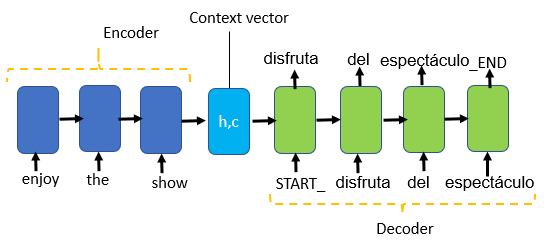

In [8]:
turkish_sentences = ["<START> "+sentence+" <END>" for sentence in data.turkish]
tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(turkish_sentences)
tokenized_turkish_sentences = tokenizer.texts_to_sequences(turkish_sentences)

In [9]:
max_output_len = np.max([len(sentence) for sentence in tokenized_turkish_sentences])
padded_turkish_sentences = preprocessing.sequence.pad_sequences(tokenized_turkish_sentences,maxlen=max_output_len,padding="post")
decoder_input_data = np.array(padded_turkish_sentences)

word_dict_turkish = tokenizer.word_index
index2wordturkish = {w_i:w for w,w_i in word_dict_turkish.items()}
num_of_turkish_words = len(word_dict_turkish)+1

print("Turkish")
print(f"En uzun cümle : {max_output_len}")
print(f"Encoder input shape : {decoder_input_data.shape}")
print(f"Toplam  kelime sayısı : {num_of_turkish_words}")

Turkish
En uzun cümle : 9
Encoder input shape : (20000, 9)
Toplam  kelime sayısı : 9650


## Decoder Target

Decoder target kısmında yukarıdaki resimde de görüldüğü gibi start tagını istemiyoruz. Bunun için start tagını çıkartıyoruz. <br>
Modele output olarak verebilmek için tüm kelimeleri one hot encoding şekline getiriyoruz. Bu sayede bir kelimeyi modele gönderdiğimizde yapılan tahminlerden en yüksek olanı seçebiliriz. Daha ileride göreceğimiz üzere modelde aktivasyon fonksiyonu olarak softmax kullancağız

In [10]:
decoder_target_data = [sentence[1:] for sentence in tokenized_turkish_sentences]

padded_turkish_sentences = preprocessing.sequence.pad_sequences(decoder_target_data,maxlen=max_output_len,padding="post")
onehot_turkish_sentences = keras.utils.to_categorical(padded_turkish_sentences,num_of_turkish_words)
decoder_target_data = np.array(onehot_turkish_sentences)

print(f"Decoder target shape : {decoder_target_data.shape}")

Decoder target shape : (20000, 9, 9650)


## Model
Embedding katmanı sadece input katmanından sonra kullanılabilir. input dim'i toplam kelime sayımız kadar olmalıdır. Bu durumda 256(output_dim/embedding vector) yani biz burada her bir kelimeyi temsil eden sayıyı bir vektöre çeviriyoruz. Basitleştirmek adına vector uzunluğu 256 olmasında 2 olsun.  [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]] Embedding layer ile 4 ve 20 sayısını dense vektörlere çevirebiliriz.

**mask_zero = True** ile kullandğımız datanın bir kısmının dolgu olduğunu yani padding yapıldığını söylüyoruz. Bu sayede padding yapılan kısımların göz ardı edilemsini sağlıyoruz. 

Daha fazla bilgi için : <br>
https://gdcoder.com/what-is-an-embedding-layer/ <br>
https://keras.io/api/layers/core_layers/embedding/ <br> 
https://www.tensorflow.org/guide/keras/masking_and_padding <br> <br>

LSTM <br> <br>
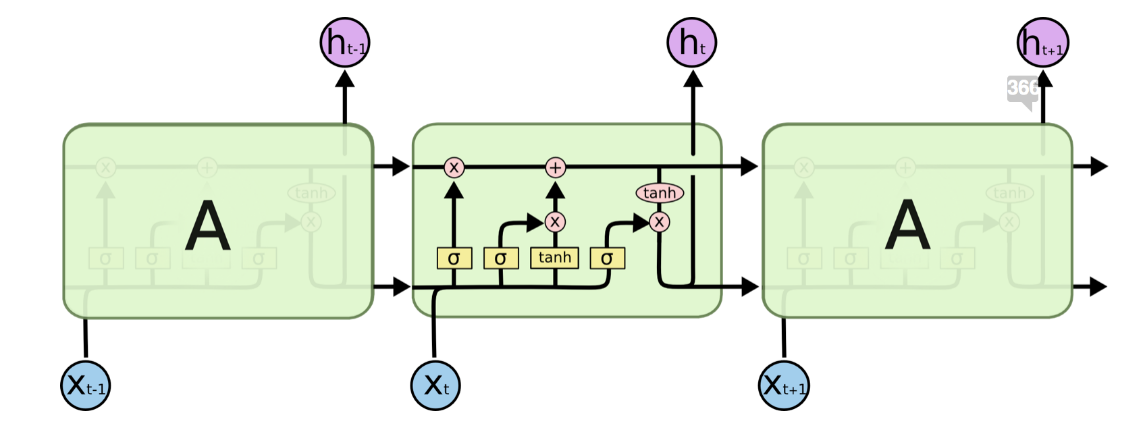 <br><br>

LSTM long-term dependency problemini çözmek için kullanılır. Uzun cümlelerde önceki kelimeleri modelin hatırlaması için kullanabiliriz. Yukarıda ki görseldede görüldüğü üzere Belli bir zamanda çıktı bir sonraki zamanda input olarak kullanılır.<br>
Encoder-decoder yapısında return statese ihtiyacımız var. Bu yapıda encoderın vectoral olarak temsil ettiğ stateleri decodera başlangıç değerleri olarak veriyoruz.
**return_states** ile son input zamanındaki output ve cell statei alırız. <br>






In [23]:
encoder_inputs = layers.Input(shape=(None,))
encoder_embedding = layers.Embedding(num_of_english_words,256,mask_zero=True,)(encoder_inputs)
encoder_outputs ,state_h,state_c = layers.LSTM(128,return_state=True)(encoder_embedding) 
encoder_states = [state_h,state_c] #(1,128) 

decoder_inputs = layers.Input(shape=(None,))
decoder_embedding = layers.Embedding(num_of_turkish_words,256,mask_zero=True)(decoder_inputs)
decoder_lstm = layers.LSTM(128,return_state=True,return_sequences=True)
#encoder statelerini decoder modele input olarka gönderiyoruz
decoder_outputs, _ , _ = decoder_lstm(decoder_embedding,initial_state=encoder_states) 
decoder_dense = keras.layers.Dense(num_of_turkish_words,activation="softmax")
output = decoder_dense(decoder_outputs)

model = keras.models.Model([encoder_inputs,decoder_inputs],output)
model.compile(optimizer="RMSprop",loss="categorical_crossentropy")
model.summary()

Model: "functional_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, None, 256)    1012224     input_20[0][0]                   
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, None, 256)    2470400     input_21[0][0]                   
_______________________________________________________________________________________

In [25]:
# input olarak encoder 20000,5 decoder input data 20000 9 decoder targer data 20000,9,9650
history = model.fit([encoder_input_data,decoder_input_data],decoder_target_data,batch_size=256,epochs=100)
model.save("/content/drive/MyDrive/Colab Notebooks/NLP/models/NMT_model.h5")

Epoch 1/100
79/79 [==============================] - 5s 67ms/step - loss: 2.6560
Epoch 2/100
79/79 [==============================] - 5s 65ms/step - loss: 2.0544
Epoch 3/100
79/79 [==============================] - 5s 66ms/step - loss: 1.8721
Epoch 4/100
79/79 [==============================] - 5s 66ms/step - loss: 1.7587
Epoch 5/100
79/79 [==============================] - 5s 66ms/step - loss: 1.6691
Epoch 6/100
79/79 [==============================] - 5s 65ms/step - loss: 1.5928
Epoch 7/100
79/79 [==============================] - 5s 64ms/step - loss: 1.5244
Epoch 8/100
79/79 [==============================] - 5s 65ms/step - loss: 1.4614
Epoch 9/100
79/79 [==============================] - 5s 64ms/step - loss: 1.4049
Epoch 10/100
79/79 [==============================] - 5s 65ms/step - loss: 1.3518
Epoch 11/100
79/79 [==============================] - 5s 65ms/step - loss: 1.3024
Epoch 12/100
79/79 [==============================] - 5s 65ms/step - loss: 1.2565
Epoch 13/100
79/79 [=====

## Inference Model
Çevirileri yapmak için bir inferencing model oluşturalım. <br>
encoder -> İnglizce cümleyi input olarak alır ve stateleri döndürür. 
decoder -> stateleri input alarak alır ve decode eder 

In [28]:
def make_inference_models():
    #input olarak inglizce cümleyi alır output olarak stateleri döndürür
    encoder_model = keras.models.Model(encoder_inputs,encoder_states)

    decoder_state_h = keras.layers.Input(shape=(128,))
    decoder_state_c = keras.layers.Input(shape=(128,))

    decoder_states_inputs = [decoder_state_h,decoder_state_c]

    decoder_outputs,state_h,state_c = decoder_lstm(decoder_embedding,initial_state=decoder_states_inputs)
    decoder_states = [state_h,state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    # girdi olarak o anki kelimeyi ve state değerlerini alır.
    decoder_model = keras.models.Model([decoder_inputs]+decoder_states_inputs,[decoder_outputs]+decoder_states)

    return encoder_model,decoder_model

encoder_model , decoder_model = make_inference_models()

print("Encoder Model :")
print(encoder_model.summary())
print("Decoder Model : ")
print(decoder_model.summary())

Encoder Model :
Model: "functional_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_19 (Embedding)     (None, None, 256)         1012224   
_________________________________________________________________
lstm_15 (LSTM)               [(None, 128), (None, 128) 197120    
Total params: 1,209,344
Trainable params: 1,209,344
Non-trainable params: 0
_________________________________________________________________
None
Decoder Model : 
Model: "functional_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, None)]       0                                            
_______________

## Sentence to Sequences 
Modele göndereceğimiz cümleleri sequencelere çevirmemiz gerekiyor. Bu sebeple cümleyi kelimelere ayırıp bu kelimelere denk gelen tokenleri kullanırız. Daha sonra bu tokenleri modele gönderebilmek için **padding** işlemi yaparız. 

In [29]:
def sentences_to_sequences(sentence):

    tokens = [word_dict_english[word] for word in sentence.lower().split()]
    return preprocessing.sequence.pad_sequences([tokens],maxlen=max_input_len,padding="post")


## Hadi Deneyelim!!!
Burada bir while döngüsü ile sürekli kullanıcıdan cümleler alalım. Bu cümleleri enc modele göndereceğiz. Tabi öncesinden sentences_to_sequences methodunu kullanarak bu cümleleri sequenceslere çevirmemiz gerekiyor. Encoder model bize state state değerleri döndürecek. <br>
Tahmin etmeye başlamadna önce decoder modele ilk göndereceğimiz token start tokeni olacka bunun yanında encoderdan aldığımız state bilgilerini de göndereceğiz. <br>
Decoder model bize decoder outputu(softmax aktivasyondan bilgi) decoder 9650 uzunluğunda bir vektör burada en bir sonra ki kelimenin en yüksek ihtimalle hangsi olduğunu bulmak için np.argmax kullanıyoruz. Bu bize en yüksek ihtimalli kelimenin indexini döndürüyor.<br>
Burdan aldığımız indexi **index2wordturkish** dictine gönderiyoruz. Buda bizer indexi verilen kelimenin ne olduğunu döndürür. Bunu yeni oluşturacağımız cümleye ekliyoruz. <br>
Eğer en yüksek ihtimalli kelime end ise yada cümlenin uzunluğu 9 dan büyükse daha fazla kelime üretmiyoruz. <br>
Ancak devam edeceksek eğer ; en son kelimenin indexini decoder modele göndermek için empty_target_seq içerisine kaydediyorız. Bunun yanında decoder modelin en son statelerinide decoder modele gönderiyoruz.

In [34]:
sentence = ""
print("Çıkmak için q yazın.")
while sentence!="q":
    
    sentence = input( 'Enter English sentence : ' ) 
    try : 
        states_values = encoder_model.predict( sentences_to_sequences( sentence) )
        empty_target_seq = np.zeros( ( 1 , 1 ) )
        empty_target_seq[0, 0] = word_dict_turkish['start']
        stop_condition = False
        decoded_sentence = ''
        while not stop_condition :
            dec_outputs , h , c = decoder_model.predict([ empty_target_seq ] + states_values )
            sampled_word_index = np.argmax( np.squeeze(dec_outputs) )
    
            sampled_word = index2wordturkish[sampled_word_index]
            decoded_sentence += ' {}'.format( sampled_word )
                
            if sampled_word == 'end' or len(decoded_sentence.split()) > max_output_len:
                stop_condition = True
                
            empty_target_seq = np.zeros( ( 1 , 1 ) )  
            empty_target_seq[ 0 , 0 ] = sampled_word_index
            states_values = [ h , c ] 
    except :
        print("Bir hata oluştu.")
        continue
    

    print( decoded_sentence )

Çıkmak için q yazın.
Enter English sentence : come
 gelin end
Enter English sentence : who are you
 sen kimsin end
Enter English sentence : q
Bir hata oluştu.
